In [1]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 529 kB 6.0 MB/s 


In [2]:
from typing import cast, Dict, List, Union

import torch
from torch import Tensor
from torch import nn
from random import shuffle
import cv2
import torchvision

import os
import time
from torch import optim
import torch
from torch import nn
from torch import optim
from torch.cuda import amp
from torch.optim import lr_scheduler
from torch.optim.swa_utils import AveragedModel
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, models, transforms

import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.utils.data as td
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from matplotlib import image
from matplotlib import pyplot


In [3]:
# os.makedirs('./COVID19-DATASET/train/covid')
# os.makedirs('./COVID19-DATASET/train/normal')
# os.makedirs('./COVID19-DATASET/train/pneumonia')
# os.makedirs('./COVID19-DATASET/train/lung_opacity')
from google.colab import drive
drive.mount('/content/drive/')

COVID_PATH = '/content/drive/MyDrive/dataset2/covid/'
NORMAL_PATH = '/content/drive/MyDrive/dataset2/normal/'
PNEUMONIA_PATH = '/content/drive/MyDrive/dataset2/pneumonia/'



Mounted at /content/drive/


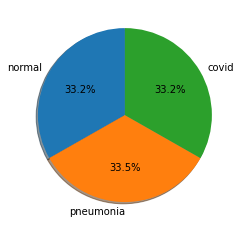

In [4]:
DATA_PATH = '/content/drive/MyDrive/dataset2'
class_names = os.listdir(DATA_PATH)
image_count = {}
for i in class_names:
    image_count[i] = len(os.listdir(os.path.join(DATA_PATH,i)))

#Plotting Distribution of Each Classes
fig1, ax1 = plt.subplots()
ax1.pie(image_count.values(),
        labels = image_count.keys(),
        shadow=True,
        autopct = '%1.1f%%',
        startangle=90)
plt.show()

In [5]:
def show_image(img):
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.imshow(img)
    ax.set_axis_off()
    plt.tight_layout()
    plt.show()

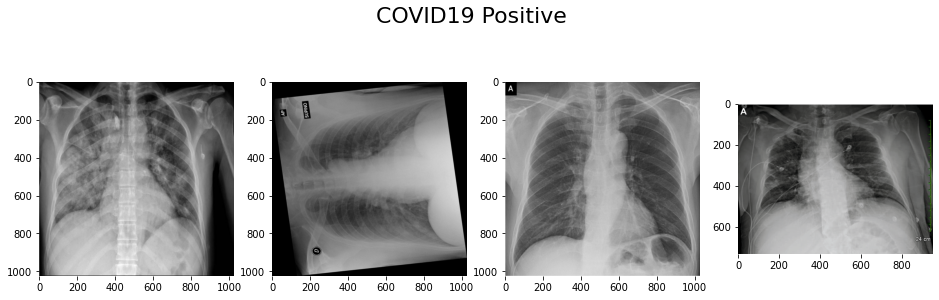

In [6]:
fig = plt.figure(figsize=(16,5))
fig.suptitle("COVID19 Positive", size=22)
img_paths = os.listdir(COVID_PATH)
shuffle(img_paths)

for i,image in enumerate(img_paths[:4]):
    img = cv2.imread(os.path.join(COVID_PATH, image))
    plt.subplot(1,4, i+1, frameon=False)
    plt.imshow(img)
    # print(os.path.join(COVID_PATH, image))
fig.show()

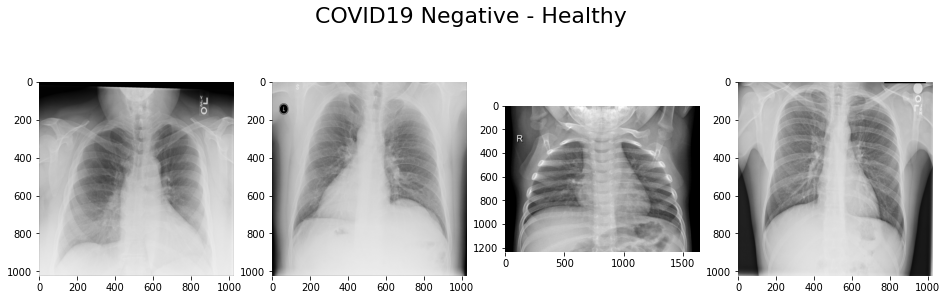

In [7]:
fig = plt.figure(figsize=(16,5))
fig.suptitle("COVID19 Negative - Healthy", size=22)
img_paths = os.listdir(NORMAL_PATH)
shuffle(img_paths)

for i,image in enumerate(img_paths[:4]):
    img = cv2.imread(os.path.join(NORMAL_PATH, image))
    plt.subplot(1,4, i+1, frameon=False)
    plt.imshow(img)
fig.show()

In [8]:
#Statistics Based on ImageNet Data for Normalisation
mean_nums = [0.5, 0.5, 0.5]
std_nums = [0.5, 0.5, 0.5]

data_transforms = {"train":transforms.Compose([
                                transforms.Resize((150,150)), #Resizes all images into same dimension
                                transforms.RandomHorizontalFlip(), #Performs Horizantal Flip over images 
                                transforms.ToTensor(), # Coverts into Tensors
                                transforms.Normalize(mean = mean_nums, std=std_nums)]), # Normalizes
                    "val": transforms.Compose([
                                transforms.Resize((150,150)),
                                transforms.CenterCrop(150), #Performs Crop at Center and resizes it to 150x150
                                transforms.ToTensor(),
                                transforms.Normalize(mean=mean_nums, std = std_nums)
                    ])}

In [9]:
def load_split_train_test(datadir, valid_size = .2):
    train_data = datasets.ImageFolder(datadir,       
                    transform=data_transforms['train']) #Picks up Image Paths from its respective folders and label them
    test_data = datasets.ImageFolder(datadir,
                    transform=data_transforms['val'])
    num_train = len(train_data)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))
    np.random.shuffle(indices)
    train_idx, test_idx = indices[split:], indices[:split]
    dataset_size = {"train":len(train_idx), "val":len(test_idx)}
    train_sampler = SubsetRandomSampler(train_idx) # Sampler for splitting train and val images
    test_sampler = SubsetRandomSampler(test_idx)
    trainloader = torch.utils.data.DataLoader(train_data,
                   sampler=train_sampler, batch_size=32) # DataLoader provides data from traininng and validation in batches
    testloader = torch.utils.data.DataLoader(test_data,
                   sampler=test_sampler, batch_size=32)
    return trainloader, testloader, dataset_size
    
trainloader, valloader, dataset_size = load_split_train_test(DATA_PATH, .2)
dataloaders = {"train":trainloader, "val":valloader}
data_sizes = {x: len(dataloaders[x].sampler) for x in ['train','val']}
class_names = trainloader.dataset.classes
print(class_names)

['covid', 'normal', 'pneumonia']


In [10]:
from numpy.core.fromnumeric import shape
def load_data(path,batch_size,input_size):
    
    normalize = transforms.Compose([
        transforms.Resize((227,227)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
        ]) 
    transform_dict = {"src":  normalize}  
    # train_path=path+"/train"
    # test_path=path+"/test"
    data = datasets.ImageFolder(root=path,transform=transform_dict["src"])
    # transform_dict1 = {"test":  normalize} 
    # test1 = datasets.ImageFolder(root=path,transform=transform_dict["test"])
    # transform_dict = {"test":  normalize}
    # test= datasets.ImageFolder(root=path,transform=transform_dict["test"])
    # train_size = int((1- (test_split + val_split)) * len(data))
    # test_size = int((1 - (val_split)) * len(data)) - train_size
    # val_size = len(data) - train_size - test_size
    train_size=int(0.75*len(data))
    test_size=int(len(data)-train_size)
    train, test = td.random_split(data,[train_size,test_size])

    data_loader_train = td.DataLoader(train,batch_size=batch_size,shuffle=True,drop_last=False,num_workers=0)
    data_loader_test = td.DataLoader(test,batch_size=batch_size,shuffle=True,drop_last=False,num_workers=0)
    # data_loader_val = td.DataLoader(val,batch_size=batch_size,shuffle=True,drop_last=False,num_workers=0)
    return data_loader_train, data_loader_test

In [11]:
data_loader_train,data_loader_test=load_data(r"/content/drive/MyDrive/dataset2",32,64)

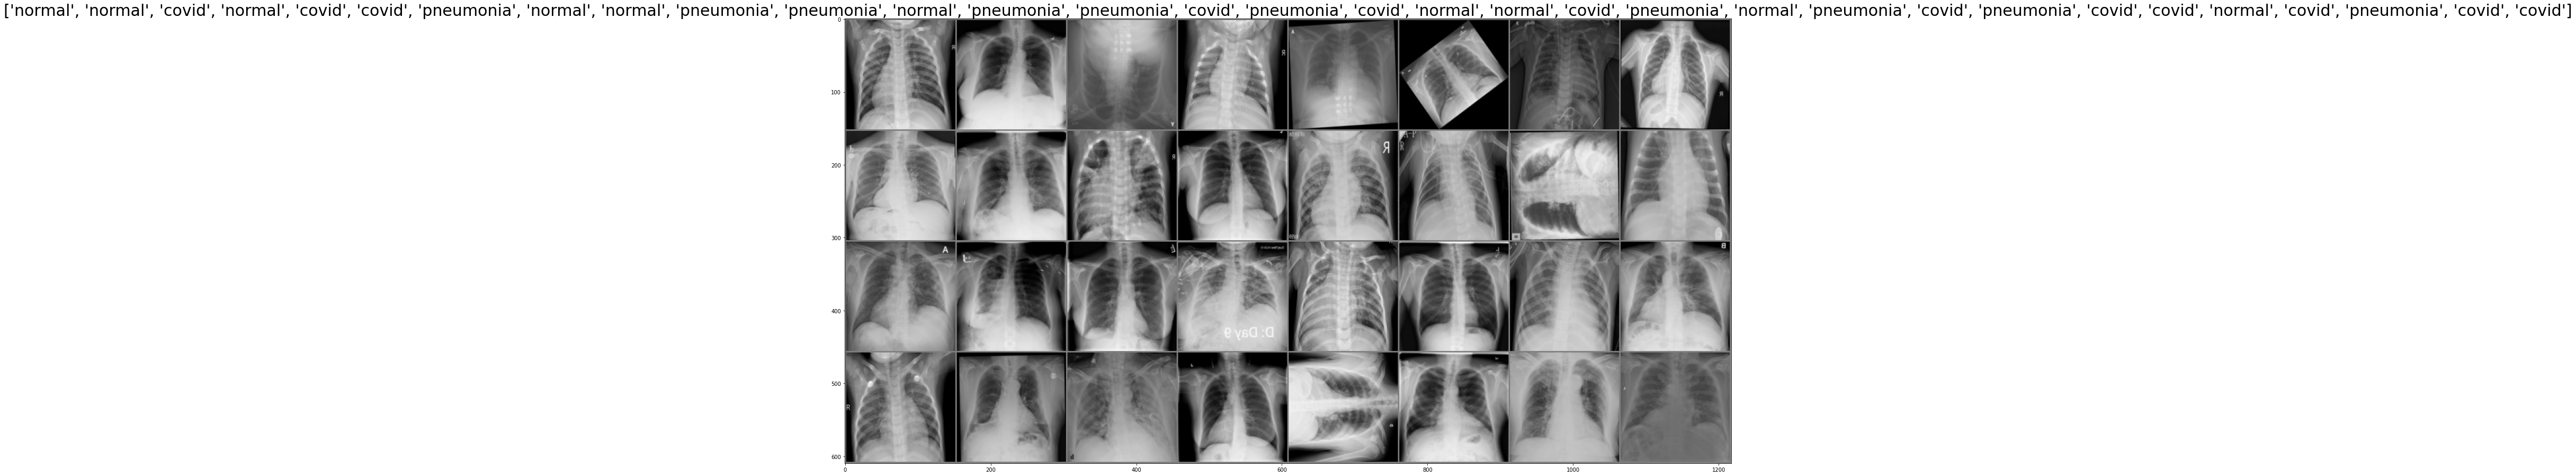

In [12]:
def imshow(inp, size =(30,30), title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = mean_nums
    std = std_nums
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=size)
    plt.imshow(inp)
    if title is not None:
        plt.title(title, size=30)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [13]:
# model = vgg11();
model = torch.hub.load('pytorch/vision:v0.10.0', 'vgg11', pretrained=False)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
# model = torch.hub.load('pytorch/vision:v0.10.0', 'vgg11_bn', pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.10.0', 'vgg13', pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.10.0', 'vgg13_bn', pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.10.0', 'vgg16', pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.10.0', 'vgg16_bn', pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.10.0', 'vgg19', pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.10.0', 'vgg19_bn', pretrained=True)

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [16]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device: {}".format(device))
model.to(device)
Accuracies = []
num_epochs = 50
total_steps = len(data_loader_train)
t1 = time.time()
for epoch in range(num_epochs):
    for i, data in enumerate(data_loader_train):
        images, labels = data[0].to(device), data[1].to(device)
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        # Backprop and optimisation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Train accuracy
        total = labels.size(0)
        _,predicted = torch.max(outputs.data, 1)
        correct = (predicted == labels).sum().item()
        if (i + 1) % 100 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
                .format(epoch + 1, num_epochs, i + 1, total_steps, loss.item(),
                    (correct / total) * 100))
            Accuracies.append((correct / total) * 100)
print("######## Training Finished in {} seconds ###########".format(time.time()-t1))

Device: cuda:0
Epoch [1/50], Step [100/325], Loss: 0.1469, Accuracy: 93.75%
Epoch [1/50], Step [200/325], Loss: 0.0101, Accuracy: 100.00%
Epoch [1/50], Step [300/325], Loss: 0.0480, Accuracy: 100.00%
Epoch [2/50], Step [100/325], Loss: 0.0366, Accuracy: 100.00%
Epoch [2/50], Step [200/325], Loss: 0.0069, Accuracy: 100.00%
Epoch [2/50], Step [300/325], Loss: 0.4400, Accuracy: 87.50%
Epoch [3/50], Step [100/325], Loss: 0.0179, Accuracy: 100.00%
Epoch [3/50], Step [200/325], Loss: 0.0652, Accuracy: 93.75%
Epoch [3/50], Step [300/325], Loss: 0.0290, Accuracy: 100.00%
Epoch [4/50], Step [100/325], Loss: 0.0021, Accuracy: 100.00%
Epoch [4/50], Step [200/325], Loss: 0.0025, Accuracy: 100.00%
Epoch [4/50], Step [300/325], Loss: 0.1640, Accuracy: 93.75%
Epoch [5/50], Step [100/325], Loss: 0.0734, Accuracy: 93.75%
Epoch [5/50], Step [200/325], Loss: 0.3316, Accuracy: 93.75%
Epoch [5/50], Step [300/325], Loss: 0.0068, Accuracy: 100.00%
Epoch [6/50], Step [100/325], Loss: 0.0228, Accuracy: 100.00%

Test Accuracy of the model on the 1731 test images: 93.93414211438474 %


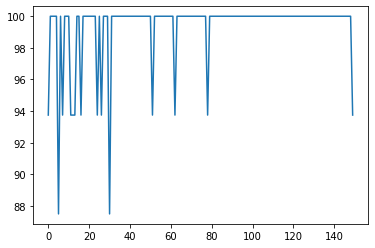

In [18]:
from torchmetrics.functional import precision_recall
from torchmetrics import F1Score
model.eval() 
preds = []
target = []
with torch.no_grad(): 
    correct = 0
    total = 0
    for data in data_loader_test:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        preds.extend(predicted)
        target.extend(labels)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print('Test Accuracy of the model on the {} test images: {} %'
        .format(total, (correct / total) * 100))
    
plt.plot(Accuracies)

In [20]:
from torchmetrics.functional import precision_recall
from torchmetrics import F1Score
from torchmetrics import ConfusionMatrix
perds1 = torch.stack(preds)
target1 = torch.stack(target)
f1 = F1Score(num_classes=4).to(device)
print(f1(perds1, target1))
print(precision_recall(perds1, target1, average='macro', num_classes=3))
confmat = ConfusionMatrix(num_classes=4).to(device)
confmat(perds1, target1)

tensor(0.9393, device='cuda:0')
(tensor(0.9407, device='cuda:0'), tensor(0.9398, device='cuda:0'))


tensor([[558,  17,   5,   0],
        [ 18, 534,   7,   0],
        [  8,  50, 534,   0],
        [  0,   0,   0,   0]], device='cuda:0')